# Example of asynchronous requests (v > 1.1)
- The scope of this example is to show how to request several products together so that internal resource usage is maximized
- We extract the spectrum of the Crab in groups of 'nscw' science windows for each year from 'start_year' to 'stop_year' included
- We use a token provided by the web interface to receive dedicated emails
- We optionally show how to fit the spectra with a broken power law using xspec

In [1]:
#A few input parameters
osa_version="OSA10.2"
source_name="Crab"
nscw=10
start_year=2004
end_year=2006
systematic_fraction = 0.01
token=''

# Token authentication

- You can provide a valid token as explained in the 'Authentication' example or skip the following cell and continue anonymously

In [2]:
import getpass
token = getpass.getpass('Insert the token')

Insert the token········


In [3]:
# To know details of the token
import oda_api.token 
oda_api.token.decode_oda_token(token)

{'sub': 'Carlo.Ferrigno@unige.ch',
 'email': 'Carlo.Ferrigno@unige.ch',
 'name': 'cferrigno',
 'roles': 'authenticated user, administrator, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares, sdss',
 'exp': 1631110932}

In [3]:
#We hardcode a catalog for the Crab
api_cat={
    "cat_frame": "fk5", 
    "cat_coord_units": "deg", 
    "cat_column_list": [
        [0, 7], 
        ["1A 0535+262", "Crab"], 
        [125.4826889038086, 1358.7255859375], 
        [84.72280883789062, 83.63166809082031], 
        [26.312734603881836, 22.016284942626953], 
        [-32768, -32768], 
        [2, 2], 
        [0, 0], 
        [0.0002800000074785203, 0.0002800000074785203]], 
    "cat_column_names": [
        "meta_ID", 
        "src_names", 
        "significance", 
        "ra", 
        "dec", 
        "NEW_SOURCE", 
        "ISGRI_FLAG", 
        "FLAG", 
        "ERR_RAD"
    ], 
    "cat_column_descr": 
        [
            ["meta_ID", "<i8"], 
            ["src_names", "<U11"], 
            ["significance", "<f8"], 
            ["ra", "<f8"], 
            ["dec", "<f8"], 
            ["NEW_SOURCE", "<i8"], 
            ["ISGRI_FLAG", "<i8"], 
            ["FLAG", "<i8"], 
            ["ERR_RAD", "<f8"]
        ], 
    "cat_lat_name": "dec", 
    "cat_lon_name": "ra"
}



## Let's get some logging

This is to help visualizing the progress.

* WARNING is the default level
* INFO writes some more information
* DEBUG is maily for developers and issue tracking

In [4]:
import logging
#default
#logging.getLogger().setLevel(logging.WARNING)
#slightly more verbose
logging.getLogger().setLevel(logging.INFO)
#all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler()) 

# Different instances of the platform

the general user will use the 'production' one, the other one is for internal testing

In [5]:

import numpy as np
import json
import oda_api.api

import oda_api

from pkg_resources import parse_version

assert parse_version(oda_api.__version__) > parse_version("1.1.0")


def dispatcher(_oda_platform='production'):
    disp = oda_api.api.DispatcherAPI(
        url = {
            'staging' : 'http://dispatcher.staging.internal.odahub.io',
            'production': 'https://www.astro.unige.ch/mmoda/dispatch-data',
        }[_oda_platform]
    )
    disp.get_instrument_description("isgri")
    return disp

disp = dispatcher('production')


--------------
query_name: src_query
 name: src_name,  value: test,  units: str, 
 name: RA,  value: 0.0,  units: deg, 
 name: DEC,  value: 0.0,  units: deg, 
 name: T1,  value: 2001-12-11T00:00:00.000,  units: None, 
 name: T2,  value: 2001-12-11T00:00:00.000,  units: None, 
 name: token,  value: None,  units: str, 

--------------
query_name: isgri_parameters
 name: user_catalog,  value: None,  units: str, 
 name: scw_list,  value: [],  units: names_list, 
 name: selected_catalog,  value: None,  units: str, 
 name: radius,  value: 5.0,  units: deg, 
 name: max_pointings,  value: 50,  units: None, 
 name: osa_version,  value: None,  units: str, 
 name: integral_data_rights,  value: public,  units: str, 
 name: E1_keV,  value: 15.0,  units: keV, 
 name: E2_keV,  value: 40.0,  units: keV, 

--------------
query_name: isgri_image_query
 product_name: isgri_image
 name: detection_threshold,  value: 0.0,  units: sigma, 
 name: image_scale_min,  value: None,  units: None, 
 name: image_sca

- Here, we collect and spectra for each year in a random sample of nscw=10 science windows
- We use the hard-coded catalog.
- note that we make a loop and submit the jobs without waiting for their completion
- at each loop, we test if they completed and we count how many have finished
- we continue to poll the dispatcher for unfinished jobs and we terminate the loop when all are done
- In this way, we let the platform optimize our requests
- There will be a convenience function in future versions of oda_api for this purpose

In [6]:
spectrum_results=[]

disp_by_ys = {}
data_by_ys = {}

par_dict = {"RA": "83.63166809082031",
            "DEC": "22.016284942626953",
            "radius": "10",
            'instrument':'isgri',
          'product': 'isgri_spectrum',
          'osa_version' : osa_version,
          'product_type': 'Real',
            'max_pointings': nscw,
          'selected_catalog' : json.dumps(api_cat)}

# Should you need to access private data, just add this option
#,"integral_data_rights": "all-private"}

if token != '':
    par_dict.update({'token': token})

while True:
    spectrum_results=[]

    for year in range(start_year, end_year+1): 
        T1_utc='%4d-01-01T00:00:00.0'%year
        T2_utc='%4d-12-31T23:59:59.0'%year 
        
        print(T1_utc,'-',T2_utc)

        par_dict.update({'T1': T1_utc,
                        'T2': T2_utc})
        
        if year >= 2016:
            osa_version='OSA11.1'
        else:
            osa_version='OSA10.2'

        #Just renaiming for a general dictionary key
        ys = year

        # We start one dipatcher for each job,
        # they will run in parallel until products are ready
        if ys not in disp_by_ys:
            disp_by_ys[ys] = oda_api.api.DispatcherAPI(url=disp.url, wait=False) #Note the flag wait=False

        _disp = disp_by_ys[ys]

        data = data_by_ys.get(ys, None)

        if data is None and not _disp.is_failed:
            
            #We submit or we poll 
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            # We retrieve data
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                data_by_ys[ys] = data                

        spectrum_results.append(data)
        
    n_complete = len([ year for year, _disp in disp_by_ys.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_ys)}")
    if n_complete == len(disp_by_ys):
        print("done!")
        break
    print("not done")


2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


- waiting for remote response (since 2021-08-31 17:52:30), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef

... query status prepared => submitted
... assigned job id: be2375ee6e04c3ef
 | the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 22 seconds (23/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating

query not complete, please poll again later


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


- waiting for remote response (since 2021-08-31 17:52:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917

... query status prepared => submitted
... assigned job id: 5ebc852ab66d5917
 | the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 27 seconds (27/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating

query not complete, please poll again later


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


- waiting for remote response (since 2021-08-31 17:53:21), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c

... query status prepared => submitted
... assigned job id: f9db3b072b6ffe3c
 | the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 6 seconds (6.6/6.6); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating

query not complete, please poll again later
- waiting for remote response (since 2021-08-31 17:53:28), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 / the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 63 seconds (14/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:53:33), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 / the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 45 seconds (17/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:53:39), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 / the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 23 seconds (6.3/6.6); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:53:45), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 - the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 80 seconds (11/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:53:50), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 - the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 62 seconds (13/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:53:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 - the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 56 seconds (12/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:54:17), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 \ the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 130 seconds (14/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:54:40), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 \ the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 113 seconds (11/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:54:46), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 \ the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 90 seconds (10/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:54:52), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 | the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 160 seconds (15/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 | the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 143 seconds (10/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:16), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 | the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 121 seconds (9.2/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 / the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 177 seconds (13/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:28), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 / the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 160 seconds (9.4/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:34), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 / the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 138 seconds (8.6/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:40), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 - the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 195 seconds (12/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:45), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 - the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 177 seconds (8.9/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:51), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 - the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 155 seconds (8.1/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:55:56), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 \ the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 227 seconds (13/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:56:18), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 \ the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 210 seconds (8.5/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:56:24), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 \ the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 188 seconds (7.9/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:56:30), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 | the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 246 seconds (13/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:56:36), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 | the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 228 seconds (8.2/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:56:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 | the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 206 seconds (7.7/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:56:48), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 / the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 263 seconds (12/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:56:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 / the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 246 seconds (8/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:57:00), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 / the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 224 seconds (7.5/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:57:06), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef
 - the job is working remotely, please wait status=submitted job_id=be2375ee in 0 messages since 281 seconds (11/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:57:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917
 - the job is working remotely, please wait status=submitted job_id=5ebc852a in 0 messages since 262 seconds (7.7/27); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:57:16), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 - the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 240 seconds (7.3/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:57:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 0 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef

... query status submitted => done
query COMPLETED SUCCESSFULLY (state done)


Is complete  True


- waiting for remote response (since 2021-08-31 17:57:36), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: CHSJDFEI89QXQBX8 job: be2375ee6e04c3ef

... query status prepared => done
... assigned job id: be2375ee6e04c3ef
query COMPLETED SUCCESSFULLY (state done)
non-waiting dispatcher: terminating
- waiting for remote response (since 2021-08-31 17:57:51), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917

... query status submitted => done
query COMPLETED SUCCESSFULLY (state done)


Is complete  True


- waiting for remote response (since 2021-08-31 17:58:06), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: KITDUODRMMKQLUK9 job: 5ebc852ab66d5917

... query status prepared => done
... assigned job id: 5ebc852ab66d5917
query COMPLETED SUCCESSFULLY (state done)
non-waiting dispatcher: terminating
- waiting for remote response (since 2021-08-31 17:58:20), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 \ the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 304 seconds (7.2/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:58:26), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 | the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 327 seconds (8.4/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:58:49), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 / the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 333 seconds (8.3/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:58:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 - the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 339 seconds (8.1/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:59:01), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c
 \ the job is working remotely, please wait status=submitted job_id=f9db3b07 in 0 messages since 345 seconds (7.9/23); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-08-31 17:59:06), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c

... query status submitted => done
query COMPLETED SUCCESSFULLY (state done)


Is complete  True


- waiting for remote response (since 2021-08-31 17:59:21), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: LZ9F8KABFTBZEW8Y job: f9db3b072b6ffe3c

... query status prepared => done
... assigned job id: f9db3b072b6ffe3c
query COMPLETED SUCCESSFULLY (state done)
non-waiting dispatcher: terminating


complete 3 / 3
done!


# Elaboration example

- This part saves the spectra in fits files and updates some keywords

In [7]:
from astropy.io import fits
# This part saves the spectra in fits files and updates some keywords
for year, data in data_by_ys.items():
    print(year)
    for ID,s in enumerate(data._p_list):
        if (s.meta_data['src_name']==source_name):
            if(s.meta_data['product']=='isgri_spectrum'):
                ID_spec=ID
            if(s.meta_data['product']=='isgri_arf'):
                ID_arf=ID
            if(s.meta_data['product']=='isgri_rmf'):
                ID_rmf=ID

    print(ID_spec, ID_arf, ID_rmf)

    spec=data._p_list[ID_spec].data_unit[1].data
    arf=data._p_list[ID_arf].data_unit[1].data
    rmf=data._p_list[ID_rmf].data_unit[2].data
    expos=data._p_list[0].data_unit[1].header['EXPOSURE']
    name=source_name+'_'+str(year)
    specname=name+'_spectrum.fits'
    arfname=name+'_arf.fits.gz'
    rmfname=name+'_rmf.fits.gz'
    data._p_list[ID_spec].write_fits_file(specname)
    data._p_list[ID_arf].write_fits_file(arfname)
    data._p_list[ID_rmf].write_fits_file(rmfname)
    hdul = fits.open(specname, mode='update')
    hdul[1].header.set('EXPOSURE', expos)
    hdul[1].header['RESPFILE']=rmfname
    hdul[1].header['ANCRFILE']=arfname
    hdul[1].data['SYS_ERR']=systematic_fraction

    hdul.close()

2004
3 4 5
2005
3 4 5
2006
3 4 5


# Elaboration 2
- If xspec is available, we make a fit of each spectrum

Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
7
 Model systematic error set to 0

Model cflux<1>*bknpower<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   bknpower   PhoIndx1            1.00000      +/-  0.0          
   5    2   bknpower   BreakE     keV      5.00000      +/-  0.0          
   6    2   bknpower   PhoIndx2            2.00000      +/-  0.0          
   7    2   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


1 spectrum  in use
 
Spectral Data File: Crab_2004_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -nanISGRI ignore: **-20.00,500.-**
      +/- -nan    

***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.
PGPLOT /png: writing new file as pgplot.png_2


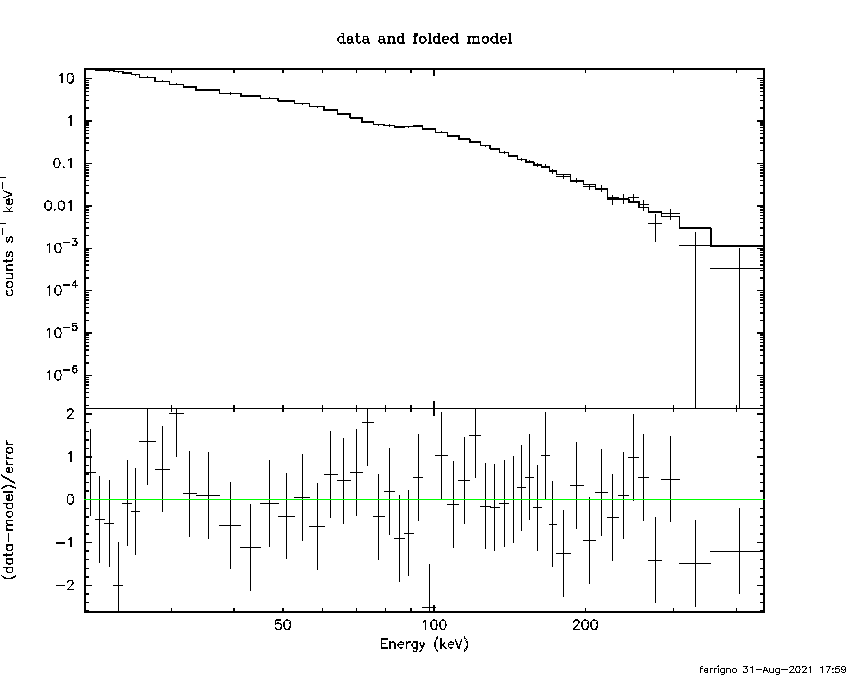


Model cflux<1>*bknpower<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
7
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   bknpower   PhoIndx1            1.00000      +/-  0.0          
   5    2   bknpower   BreakE     keV      5.00000      +/-  0.0          
   6    2   bknpower   PhoIndx2            2.00000      +/-  0.0          
   7    2   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


1 spectrum  in use
 
Spectral Data File: Crab_2005_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -nan      +/- -nan     
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 1.879e+04 sec
 Using fit

***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.


     8 channels (1-8) ignored in spectrum #     1
     2 channels (61-62) ignored in spectrum #     1

Fit statistic  : Chi-Squared                    -nan     using 52 bins.

Test statistic : Chi-Squared                    -nan     using 52 bins.
 Current data and model not fit yet.


Fit statistic  : Chi-Squared                    -nan     using 52 bins.

Test statistic : Chi-Squared                    -nan     using 52 bins.
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                    -nan     using 52 bins.

Test statistic : Chi-Squared                    -nan     using 52 bins.
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                19542.13     using 52 bins.

Test statistic : Chi-Squared                19542.13     using 52 bins.
 Null hypothesis probability of 0.00e+00 with 47 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                19542.13     using 52 bins.

Test statistic : Chi-Sq

PGPLOT /png: writing new file as pgplot.png_2


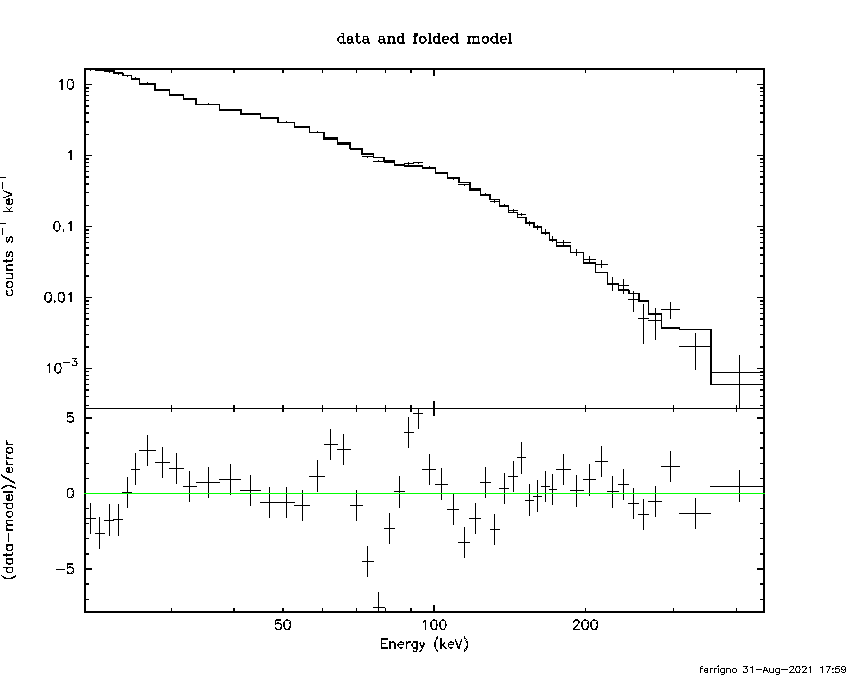

***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.


|/N    Lvl    3:lg10Flux    4:PhoIndx1    6:PhoIndx2
231.336      0.032211     -3      -7.82041       2.19156       2.47344
 Variances and Principal Axes
                 3        4        6  
 1.0359E-06|  0.9990  -0.0435  -0.0093  
 2.1153E-05| -0.0440  -0.9969  -0.0657  
 1.1918E-03|  0.0064  -0.0660   0.9978  
----------------------------------------

  Covariance Matrix
        1           2           3   
   1.124e-06   3.785e-07   7.669e-06
   3.785e-07   2.621e-05  -7.710e-05
   7.669e-06  -7.710e-05   1.187e-03
------------------------------------

Model cflux<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      20.0000      frozen
   2    1   cflux      Emax       keV      80.0000      frozen
   3    1   cflux      lg10Flux   cgs      -7.82041     +/-  1.06002E-03  
   4    2   bknpower   PhoIndx1            2.19156      +/-  5.11997E-03  
   5    2   bknpower   BreakE     keV      100.

PGPLOT /png: writing new file as pgplot.png_2


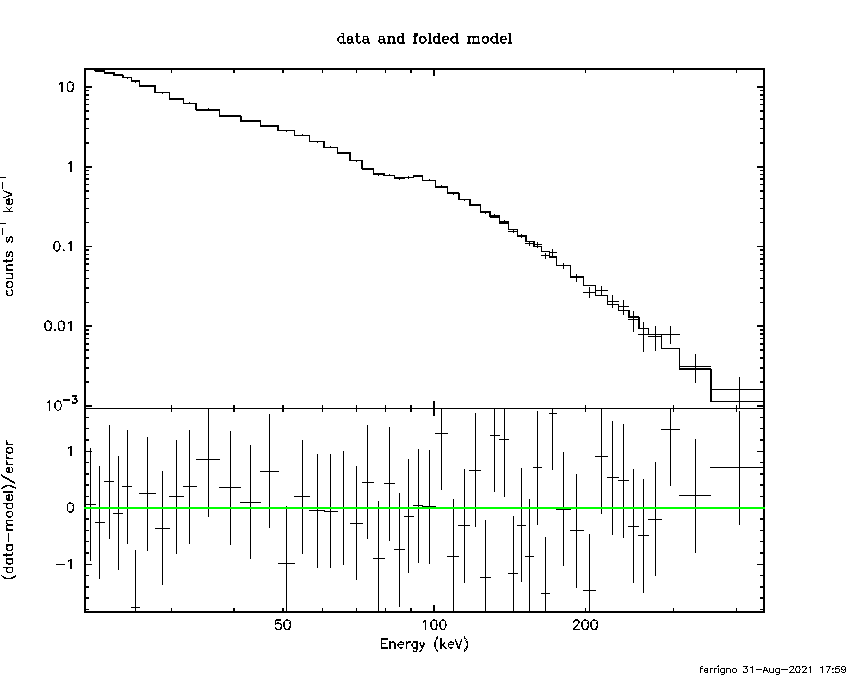

   11903.5      -4      -7.83229       2.07958       2.25587
29.9577      473.3        -5      -7.83386       2.07700       2.25598
29.9576      3.49072      -6      -7.83387       2.07699       2.25598
 Variances and Principal Axes
                 3        4        6  
 1.0804E-06|  0.9998  -0.0198  -0.0083  
 2.2834E-05|  0.0202   0.9978   0.0633  
 1.3097E-03| -0.0070   0.0635  -0.9980  
----------------------------------------

  Covariance Matrix
        1           2           3   
   1.154e-06  -1.446e-07   9.210e-06
  -1.446e-07   2.801e-05  -8.153e-05
   9.210e-06  -8.153e-05   1.304e-03
------------------------------------

Model cflux<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      20.0000      frozen
   2    1   cflux      Emax       keV      80.0000      frozen
   3    1   cflux      lg10Flux   cgs      -7.83387     +/-  1.07426E-03  
   4    2   bknpower   PhoIndx1            

In [8]:
try:

    import xspec
    import shutil
    from IPython.display import Image
    from IPython.display import display 

    xspec.Fit.statMethod = "chi"

    #init dictionaries
    fit_by_lt={}

    model='cflux*bknpow'

    xspec.AllModels.systematic=0.0
    low_energies=[20]
    freeze_pow_ebreak=1

    for year in range(start_year,end_year+1):

        for c_emin in low_energies: #np.linspace(17,40,5):    
            xspec.AllData.clear()

            m1=xspec.Model(model)

            specname=source_name+'_'+str(year)+'_spectrum.fits'

            xspec.AllData(specname)

            s = xspec.AllData(1)

            isgri = xspec.AllModels(1)

            print(m1.nParameters)

            xspec.AllData.ignore('bad')
            xspec.AllData.ignore('500.0-**')

            ig="**-%.2f,500.-**"%c_emin
            print("ISGRI ignore: "+ ig)
            s.ignore(ig)

            #Key for output
            lt_key='%d_%.10lg'%(year, c_emin)

            isgri.cflux.lg10Flux=-8            

            isgri.cflux.Emin=20.
            isgri.cflux.Emax=80.

            isgri.bknpower.norm = "1,-1"
            isgri.bknpower.PhoIndx1 = "2.0,.01,1.,1.,3.,3."
            isgri.bknpower.PhoIndx2 = "2.2,.01,1.,1.,3.,3."
            isgri.bknpower.BreakE = "100,-1,20,20,300,300"

            xspec.Fit.perform()
            isgri.bknpower.BreakE.frozen = freeze_pow_ebreak  > 0

            xspec.Fit.perform()

            max_chi=np.ceil(xspec.Fit.statistic / xspec.Fit.dof)

            xspec.Fit.error("1.0 max %.1f 1-%d"%(max_chi,m1.nParameters))


            fit_by_lt[lt_key]=dict(
                    emin=c_emin,
                    year=year,
                    chi2_red=xspec.Fit.statistic/xspec.Fit.dof,                                
                    chi2=xspec.Fit.statistic,
                    ndof=xspec.Fit.dof,                                    
                )

            for i in range(1,m1.nParameters+1): 
                if (not isgri(i).frozen) and (not bool(isgri(i).link)):
                    #use the name plus position because there could be parameters with same name from multiple 
                    #model components (e.g., several gaussians)
                    print(isgri(i).name, "%.2f"%(isgri(i).values[0]), isgri(i).frozen,bool(isgri(i).link) )
                    fit_by_lt[lt_key][isgri(i).name+"_%02d"%(i)]=[ isgri(i).values[0], isgri(i).error[0], isgri(i).error[1] ]



            xspec.Plot.device="/png"
            #xspec.Plot.addCommand("setplot en")
            xspec.Plot.xAxis="keV"
            xspec.Plot("ldata del")
            xspec.Plot.device="/png"

            fn="fit_%s.png"%lt_key
            fit_by_lt[lt_key]['plot_fname'] = fn

            shutil.move("pgplot.png_2", fn)

            _=display(Image(filename=fn,format="png"))

except ImportError:
    print("no problem!")